# The Hunt For Chinese Restaurants In New York City

Author: Brandon Tan 

## 1. Introduction 
The purpose of this Project is to combined all the knowledge that we have learnt over the course of this course. For this very specific project we will leverage the Foursquare location API to explore New York City and find all the chinese restaurants around

## 2. Business Problem 
New York City, home to 8.4 million people is one of the most famous and affluent cities in the United States of America. The population density is 27,000 people per square mile, with an area of 468.19 square miles. With such density and wealth, it creates tremendous business opportunity for a kinds of sectors. The food industry is one that is particularly competitive, ultilizing my skills and knowledge for interpreting data my objective is to find all the locations of Chinese Restaurants in NYC to study the competiton. 

## 3. Project Goal
Population density is a key aspect of analyzing data on cities, and it plays an important part in issues such as transport, infrastructure and living standards for residents. Some people prefer a slow pace and less crowded cities with open spaces, while others would rather have the fast pace city life. In New York, not just Pizzerias or Coffee Shops are famous, but also there is fine Michelin starred restaurants with the most diverse type of food. With this diversity of restaurants with different categories like Chinese, Indian, French, Brazilian, etc. So here, the main goal is to find answers to the following questions:

- List and visualize all major parts of New York City that has great restaurants.
- Where is the best location in NYC for chinese restaurants?
- Which areas poses a great potential for a new chinese restaurant business?
- Which all areas lack Chinese Resturants?
- Which is the best place to stay if you prefer Chinese Food?

## 4.Data Understanding 

New York City's have a collection of restaurants from across the city that defined by a diverse culture with a lot of diverse type of food, each belonging to different categories like Chinese, Indian, French, Brazilian, etc. For this project, we will use an open data as following below: New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.

- Data set: https://cocl.us/new_york_dataset
- Description: This dataset contains information such as Borugh, Neighbourhood, Lat & Long

Venues of different restaurant cruisines

- Data set: Foursquare API
- Description: Foursqaure API allows us to gain access to venues of different resturants, specifically chinese resturants. 

GeoSpace

- Data set : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description: By using this geo, space data we will get the New York Borough boundaries that will help us visualize choropleth map.

| Borough | Neighborhood | Latitude	| Longitude |
| --- | --- | --- | --- |
| Bronx | Wakefield | 40.894705 | -73.847201|
| Bronx | Co-op City | 40.874294 | -73.829939|
| Bronx |Eastchester | 40.887556 | -73.827806|
| Bronx | Fieldston | 40.895437 | -73.905643|
| Bronx | Riverdale | 40.890834 | -73.912585|




# Importing Libraries

In [1]:
import requests 
import pandas as pd 
import numpy as np 
import random 
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

**DEFINING FOURSQUARE CREDENTIALS**


In [2]:
CLIENT_ID = '3HA5I1NALIQBX0X2QJAWUTAIJNG4N2GOWJEXWVWFP4FYAO3V'    
CLIENT_SECRET = 'HSMUV2PIJJG3RESNP4U53NKWE2XDP0DM3M5FEMPAZFYJAJ5X'
VERSION = '20180604'
# We will get 100 venues within the radius of 1km for a given lat & long
LIMIT = 100
radius=1000

In [3]:
# Defining a geo location function
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
# Venues where we find the best ratings
address = 'New York, Manhattan'
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

Geograpical coordinate of New York, Manhattan are 40.7896239, -73.9598939.


**DEFININF A FUNCTION TO GET VENUES**

In [5]:
def get_venues(lat,lng):
    
    # URL link to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # Retrieve all data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

**DEFININF A FUNCTION TO COLLECT VENUE DETAILS**

In [23]:
def get_venue_details(venue_id):
  
    # URL link to fetch data from foursquare api
    urls = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # Retrieve all data
    results = requests.get(urls).json()
    venue_data=results['response']['Venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

**DEFININF A FUNCTION TO GET NEW YORK DATA**

In [7]:
def get_new_york_data():
  
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data = get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**NUMBER OF DIFFERENT NEIGHBOURHOODS IN NYC**

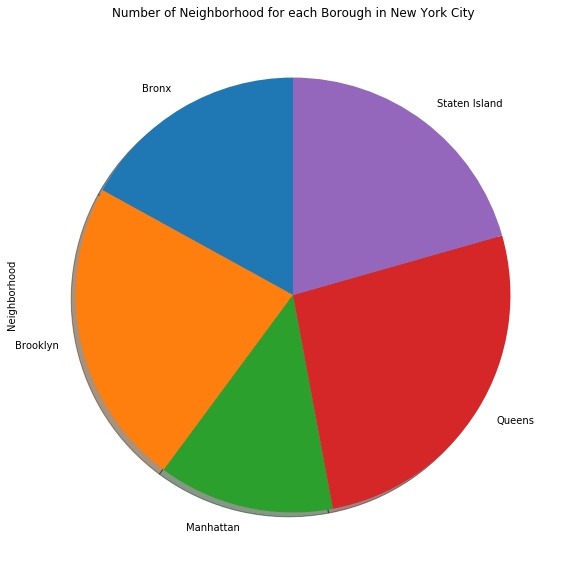

In [10]:
# illustrate using pie chart
plt.title('Number of Neighborhood for each Borough in New York City')
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='pie', shadow = True,startangle=90,figsize=(110,10))

**PREPARING NEIGHBOURING LIST THAT CONTAINS CHINESE RESTAURANTS**

In [11]:
column_names = ['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny = pd.DataFrame(columns=column_names)
count = 1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants = venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category = resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:2
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:3
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:3
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:4
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:0
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:2
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:4
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:3
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:2
( 145 / 306 ) Chinese Resturants in Glendale, Queens:1
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:3
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:3
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:2
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:3
( 150 / 306 ) Chinese Resturants in College Point, Queens:3
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:1
( 152 / 306 ) Chinese Resturants in Bayside, Queens:2
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:2
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:5
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:5
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:0
( 158 / 306 ) Chinese Resturants

( 276 / 306 ) Chinese Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Chinese Resturants in Flatiron, Manhattan:1
( 278 / 306 ) Chinese Resturants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Chinese Resturants in Blissville, Queens:4
( 280 / 306 ) Chinese Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Chinese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Chinese Resturants in Weeksville, Brooklyn:6
( 283 / 306 ) Chinese Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Chinese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Chinese Resturants in Manor Heights, Staten Island:2
( 286 / 306 ) Chinese Resturants in Willowbrook, Staten Island:2
( 287 / 306 ) Chinese Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Chinese Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Chinese Resturants in Roxbury, Queens:0
( 290 / 306 ) Chinese Resturants in Homecrest, Brooklyn:3
( 291 / 306 ) Chinese Resturants in Middle Village, Queens:2
( 292 / 306 ) Chine

**VIEWING OUR CHINESE RESTURANTS DATA**

In [12]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
2,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
3,Manhattan,Marble Hill,4bcbae5d68f976b01da46183,Ming Moon Buffet
4,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant


Now lets check the number of restaurants available in the location

In [13]:
chinese_rest_ny.shape

(420, 4)

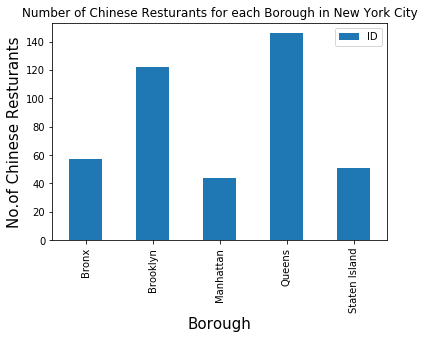

In [14]:
plt.title('Number of Chinese Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize=15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

Out of 420 chinese resturants, Queens has the higest number of resturants

Now we check the number of Chinese Resturants for each Neighborhood in New York City

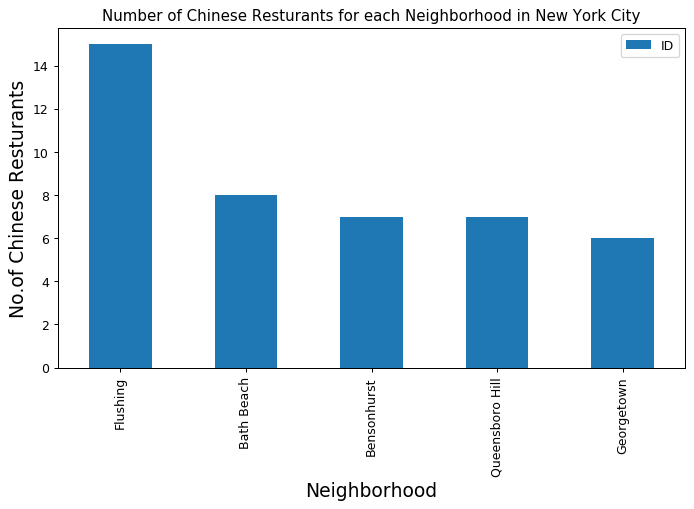

In [15]:
plt.figure(figsize=(9,5), dpi=90)
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

From here we can see flushing has the most chinese resturants 

In [16]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
191,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
192,Queens,Flushing,5ff6c122787c0c7516db62f1,江湖烤肉 Gan-Hoo BBQ
193,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
194,Queens,Flushing,5990ab0a826444188d18dabc,Szechuan House
195,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang
196,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
197,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
198,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
199,Queens,Flushing,4d1bcddc1356224bc6410abe,OK Ryan
200,Queens,Flushing,4ac38216f964a520929b20e3,Golden Shopping Mall


Name of all the chinese resturants in flushing

**PREPARE NEIGHBOURING LIST THAT CONTAINS CHINESE RESTAURANTS**

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)

count = 1

for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [80]:
# Converting the datatype for futher expolration
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Name']=chinese_rest_stats_ny['Name'].astype('|S')
chinese_rest_stats_ny['ID']=chinese_rest_stats_ny['ID'].astype('|S')
chinese_rest_stats_ny['Neighborhood']=chinese_rest_stats_ny['Neighborhood'].astype('|S')
chinese_rest_stats_ny['Borough']=chinese_rest_stats_ny['Borough'].astype('|S')

In [89]:
# Chinese Restaurant with the higest tip
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                            b'Bronx'
Neighborhood                  b'Co-op City'
ID              b'4c66dcfaaebea593955a74d0'
Name                      b'Chinese Buffet'
Likes                                     7
Rating                                  5.2
Tips                                     10
Name: 0, dtype: object

In [91]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                            b'Bronx'
Neighborhood                     b'Fordham'
ID              b'566f33e7498e44c2501bda81'
Name                       b'Panda Express'
Likes                                    12
Rating                                  7.7
Tips                                      2
Name: 19, dtype: object

In [92]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                            b'Bronx'
Neighborhood                     b'Fordham'
ID              b'566f33e7498e44c2501bda81'
Name                       b'Panda Express'
Likes                                    12
Rating                                  7.7
Tips                                      2
Name: 19, dtype: object

Now lets find the neighbourhood with the maximum average rating

In [105]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
round(ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(15),2)

,Neighborhood,Average Rating
9,b'Fordham',7.70
0,b'Bay Ridge',7.20
27,b'Unionport',7.10
13,b'Melrose',7.00
8,b'Eastchester',6.70
2,b'Bedford Park',6.45
3,b'City Island',6.30
17,b'North Riverdale',5.95
4,b'Co-op City',5.20
18,b'Norwood',4.30


Let now look at the top average rating of chinese restaurants

In [103]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
round(ny_borough_stats.sort_values(['Average Rating'],ascending=False).head(),2)

,Borough,Average Rating
1,b'Brooklyn',7.20
2,b'Manhattan',3.75
0,b'Bronx',2.35


For Visuals lets consider neighbourhood with average ratings greater than 6.0

In [106]:
ny_neighborhood_stats = ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=6.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,b'Bay Ridge',7.20
2,b'Bedford Park',6.45
3,b'City Island',6.30
8,b'Eastchester',6.70
9,b'Fordham',7.70
13,b'Melrose',7.00
27,b'Unionport',7.10


**FINALLY AN OVERVIEW OF OUR WHOLE DATA**

In [109]:
chinese_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,b'Bronx',b'Co-op City',b'4c66dcfaaebea593955a74d0',b'Chinese Buffet',7.0,5.2,10.0
1,b'Bronx',b'Eastchester',b'4dabc3dc93a04642f09ccabd',b'Xing Lung Chinese Restaurant',6.0,6.7,0.0
2,b'Manhattan',b'Marble Hill',b'4d965fd061a3a1cde4989a42',b'Lucky Star Chinese Restaurant',4.0,7.5,5.0
3,b'Manhattan',b'Marble Hill',b'0',b'0',0.0,0.0,0.0
4,b'Bronx',b'Norwood',b'4e4d0387bd413c4cc66dfd72',b'Hung Hing Chinese Restaurant',5.0,6.6,2.0
5,b'Bronx',b'Norwood',b'4e2e08021838f1c552b6b8eb',b'Choi Yuan - Chinese Restaurant',6.0,6.3,8.0
6,b'Bronx',b'Norwood',b'0',b'0',0.0,0.0,0.0
7,b'Bronx',b'Baychester',b'4c1a8bac8b3aa593a8c8955f',b'Dragon City',1.0,6.7,8.0
8,b'Bronx',b'Baychester',b'0',b'0',0.0,0.0,0.0
9,b'Bronx',b'Baychester',b'0',b'0',0.0,0.0,0.0


  # Executive Summary 
  
  ## Modeling
  This project's main function is data exploration, hence no modeling is required. 
  
  ## Evaluation 
  Base on our findings we now can identify the areas where competiton for chinese restaurants are high, and potentially use this information to our advantage if we want to start our own fried rice shop
  
  ## Graditude 
  Thank you for marking my work, have a great day ahead
